Before you run this on Colab you have to move the 'CNN-DiseaseDet..' folder to your google drive or clone the Githup repo to the drive

In [ ]:
#!pip install tensorflow

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

You have to allow colab access to your google drive

In [38]:
# import libraries
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [39]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 40
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "./PlantImgData"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

In [40]:
def dataset_splitting(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [41]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [42]:
train_data, val_data, test_data = dataset_splitting(dataset)

In [64]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [43]:
print(train_data)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [44]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_data), len(val_data), len(test_data)))
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

Size of Data is :68 
Batch size of Training Data is :54
Batch size of Validation Data is :6 
Batch size of Testing Data is :8 
3 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


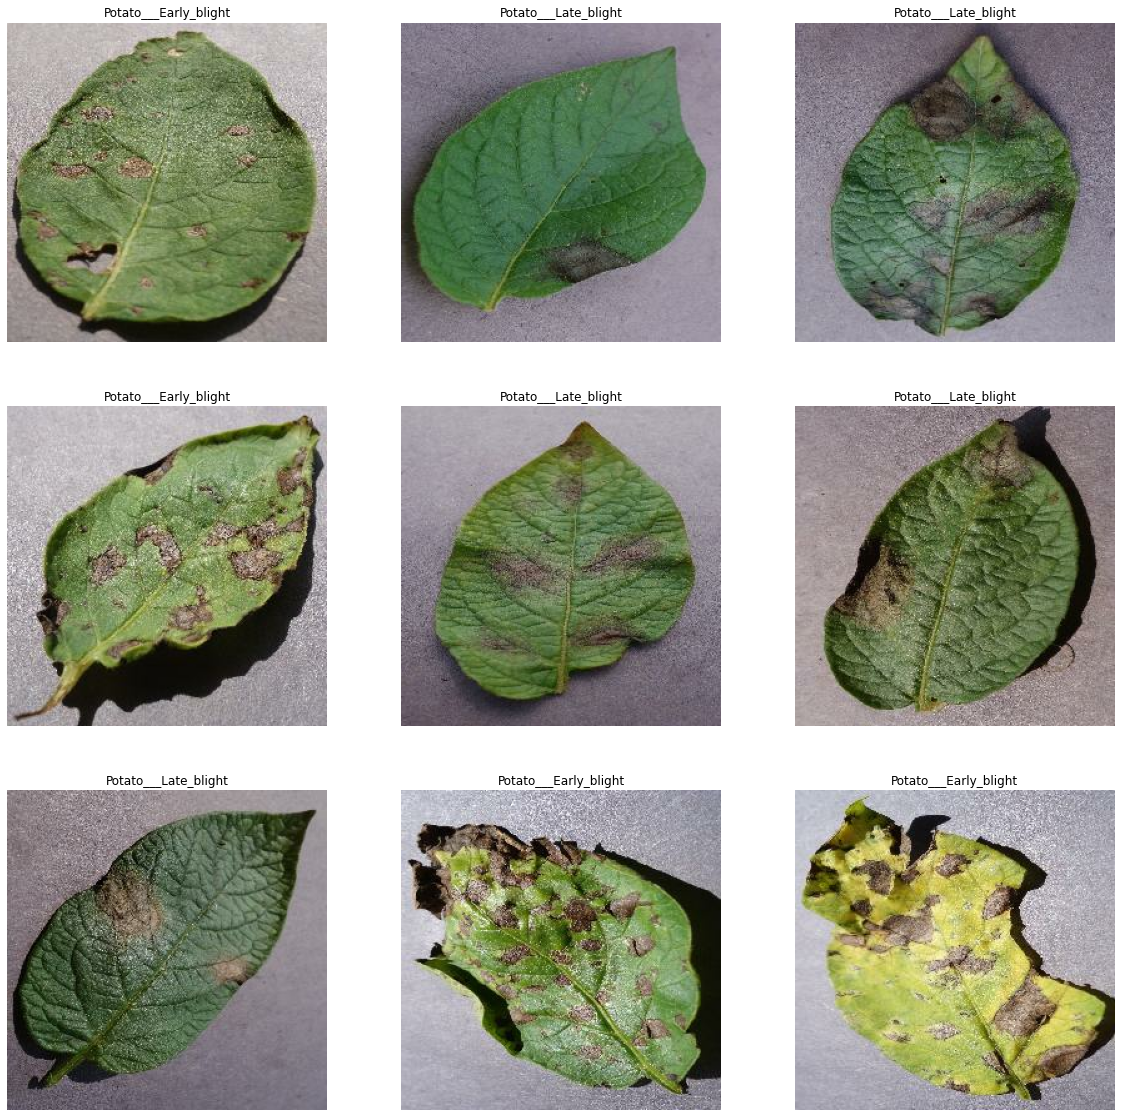

In [45]:
plt.figure(figsize=(20, 20))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [46]:
# caching,shuffle and prefetching the data
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [47]:
# Image Preprocessing : Rescaling and Resizing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [48]:
# Data augmentation by flipping and rotating existing images
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(factor = 0.5)
])

The Model

In [49]:
# Creating Convolution layer 
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'softmax'),

])


model.build(input_shape = input_shape)

In [50]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        9280      
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [51]:
# Optimizing the model 'SparseCategoricalCrossentropy'=>as there are many categorical classes of data
model.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy'])

In [52]:
#Fit the model with training data and also pass validation data
history = model.fit(
train_data, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose = 1, validation_data = val_data)

Epoch 1/40
54/54 [==============================] - 166s 3s/step - loss: 1.3773 - accuracy: 0.4683 - val_loss: 0.9794 - val_accuracy: 0.4479
Epoch 2/40
54/54 [==============================] - 178s 3s/step - loss: 0.8829 - accuracy: 0.5270 - val_loss: 0.9064 - val_accuracy: 0.5260
Epoch 3/40
54/54 [==============================] - 160s 3s/step - loss: 0.7482 - accuracy: 0.6755 - val_loss: 0.7145 - val_accuracy: 0.6615
Epoch 4/40
54/54 [==============================] - 164s 3s/step - loss: 0.5233 - accuracy: 0.7811 - val_loss: 0.4248 - val_accuracy: 0.8125
Epoch 5/40
54/54 [==============================] - 168s 3s/step - loss: 0.4445 - accuracy: 0.8087 - val_loss: 0.4110 - val_accuracy: 0.8125
Epoch 6/40
54/54 [==============================] - 161s 3s/step - loss: 0.3191 - accuracy: 0.8727 - val_loss: 0.2371 - val_accuracy: 0.8958
Epoch 7/40
54/54 [==============================] - 151s 3s/step - loss: 0.2789 - accuracy: 0.8891 - val_loss: 0.2552 - val_accuracy: 0.8854
Epoch 8/40
54

In [53]:
scores = model.evaluate(train_data)

54/54 [==============================] - 40s 747ms/step - loss: 0.1426 - accuracy: 0.9489


In [54]:
history

In [55]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 54}

In [56]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [57]:
# Getting the model history to analyse
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

In [58]:
print(val_acc)

[0.4479166567325592, 0.5260416865348816, 0.6614583134651184, 0.8125, 0.8125, 0.8958333134651184, 0.8854166865348816, 0.7916666865348816, 0.9166666865348816, 0.9375, 0.9427083134651184, 0.953125, 0.8958333134651184, 0.921875, 0.953125, 0.984375, 0.9322916865348816, 0.96875, 0.9166666865348816, 0.8854166865348816, 0.9479166865348816, 0.875, 0.984375, 0.96875, 0.9166666865348816, 0.96875, 0.9427083134651184, 0.9322916865348816, 0.9583333134651184, 0.9322916865348816, 0.9322916865348816, 0.9270833134651184, 0.9114583134651184, 0.9895833134651184, 0.9739583134651184, 0.9375, 0.9635416865348816, 0.9427083134651184, 0.9791666865348816, 0.9635416865348816]


Text(0.5, 1.0, 'Training and Validation Loss')

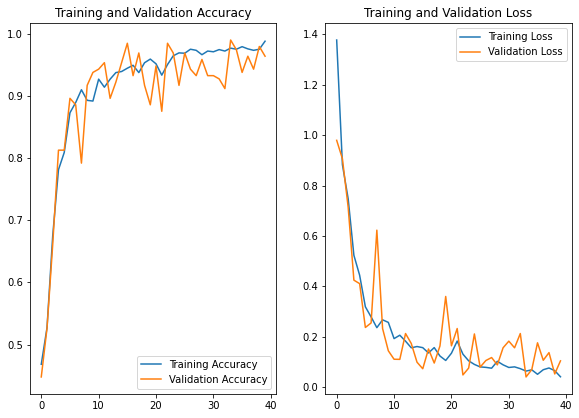

In [59]:
#graphs for accuracy and loss of training and validation data
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.plot(range(EPOCHS), train_acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy') 

plt.subplot(2,3,2)
plt.plot(range(EPOCHS), train_loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

First Image of batch to predict :
Actual label :  Potato___Early_blight
1/1 [==============================] - 1s 836ms/step
Predicted label :  Potato___Early_blight


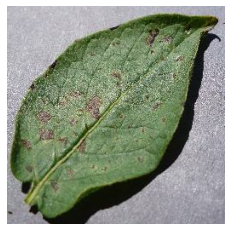

In [60]:
#plotting image
for batch_image, batch_label in train_data.take(1):
    first_image = batch_image[0].numpy().astype('uint8')
    first_label = class_names[batch_label[0]]
    
    print('First Image of batch to predict :')
    plt.imshow(first_image)
    print('Actual label : ', first_label)
    
    batch_prediction = model.predict(batch_image)
    print('Predicted label : ', class_names[np.argmax(batch_prediction[0])])
    plt.axis('off')

tf.Tensor(
[[[[133. 119. 119.]
   [134. 120. 120.]
   [143. 129. 129.]
   ...
   [140. 126. 125.]
   [138. 124. 123.]
   [141. 127. 126.]]

  [[129. 115. 115.]
   [129. 115. 115.]
   [137. 123. 123.]
   ...
   [144. 130. 129.]
   [145. 131. 130.]
   [149. 135. 134.]]

  [[131. 117. 117.]
   [128. 114. 114.]
   [134. 120. 120.]
   ...
   [153. 139. 138.]
   [161. 147. 146.]
   [169. 155. 154.]]

  ...

  [[182. 173. 178.]
   [183. 174. 179.]
   [182. 173. 178.]
   ...
   [194. 186. 184.]
   [191. 183. 181.]
   [190. 182. 180.]]

  [[180. 171. 176.]
   [182. 173. 178.]
   [182. 173. 178.]
   ...
   [190. 182. 180.]
   [187. 179. 177.]
   [190. 182. 180.]]

  [[183. 174. 179.]
   [184. 175. 180.]
   [184. 175. 180.]
   ...
   [180. 172. 170.]
   [183. 175. 173.]
   [192. 184. 182.]]]


 [[[188. 190. 202.]
   [186. 188. 200.]
   [184. 186. 198.]
   ...
   [152. 149. 160.]
   [147. 144. 155.]
   [144. 141. 152.]]

  [[190. 192. 204.]
   [188. 190. 202.]
   [187. 189. 201.]
   ...
   [164. 1

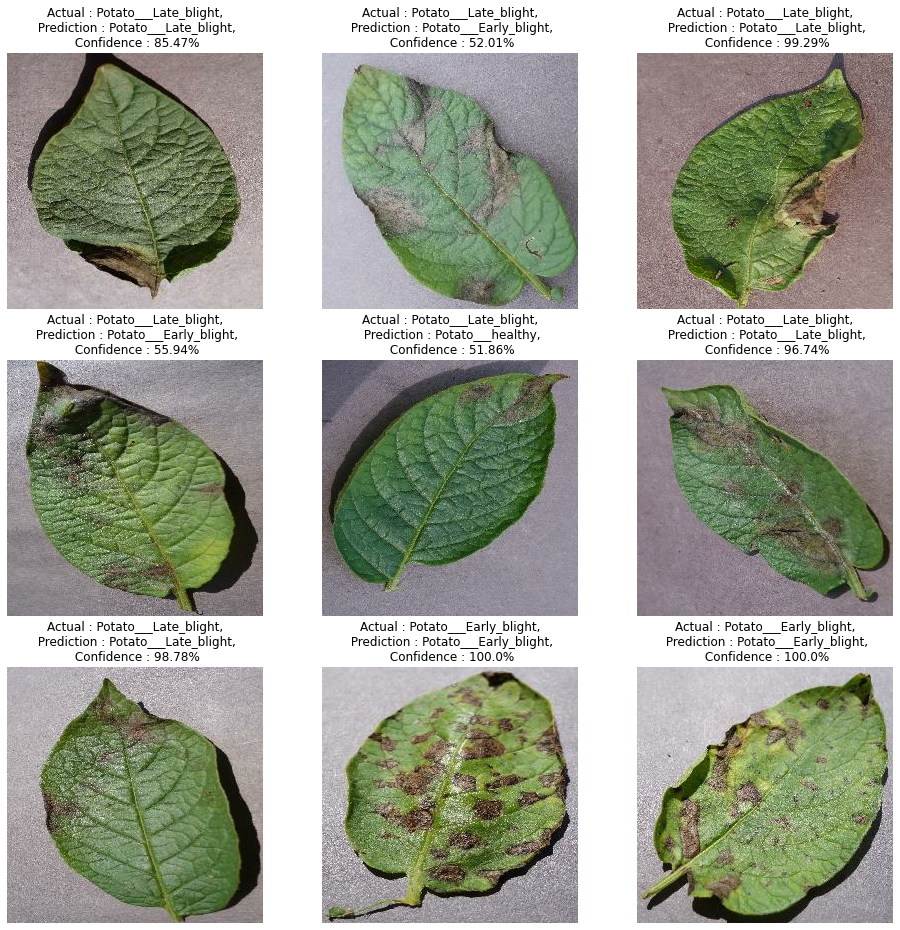

In [63]:
# plotting batch of images with its actual label, predicted label and confidence
plt.figure(figsize = (16,16))
for batch_image, batch_label in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = class_names[batch_label[i]]
        print(batch_image)
        plt.imshow(image)
    
        batch_prediction = model.predict(batch_image)
        predicted_class = class_names[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)
        
        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')
    
        plt.axis('off')

In [62]:
model_version = max([int(i) for i in (os.listdir("../models")+[0])]) + 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets
